# Proyecto de Programación: Dataset Shoes vs Sandals vs Boots
### Grupo 3: Guillermo Calderón Hernández, Luis Jama Tello y Guillermo Roberto Agusti
#### Link dataset: htps://bit.ly/3U0QpZj

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=6996dcaff45fe5659e416840e57704e01a72ddc9a4afe063e81a8486c4e1c153
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [3]:
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luisjham","key":"7f5f28ed549ad4cd1ec09c72e701332c"}'}

In [4]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images --force


 96% 45.0M/47.0M [00:00<00:00, 106MB/s]
100% 47.0M/47.0M [00:00<00:00, 106MB/s]


In [7]:
# Creemos un directorio para descomprimir los datos
!rm -R dataset/
!mkdir -p dataset

In [8]:
# Descomprimimos los datos y los dejamos listos para trabajar
# /content/shoe-vs-sandal-vs-boot-dataset-15k-images.zip

# /content/dataset/Shoe vs Sandal vs Boot Dataset

!unzip shoe-vs-sandal-vs-boot-dataset-15k-images.zip -d '/content/dataset/'
!mv /content/dataset/Shoe\ vs\ Sandal\ vs\ Boot\ Dataset/*  /content/dataset
!rm -R "/content/dataset/Shoe vs Sandal vs Boot Dataset"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (10).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (100).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1000).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1001).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1002).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1003).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1005).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1006).jpg  
  inflating: /content/dataset/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1007).jpg  
  inflating: /content

In [ ]:
!pwd

/content


In [9]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report

batch_size = 32
seed = 42

In [10]:
# Funciones base
def visualize_learning_curve(H):
  epochs = len(H.history["loss"])
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()


def evaluate_model(model, x, y):
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x, batch_size=batch_size)
  print(classification_report(y, predictions.argmax(axis=1)))

#### Preparación del Dataset

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Using 3000 files for validation.
(32, 102, 136, 3)
(32,)
['Boot', 'Sandal', 'Shoe']


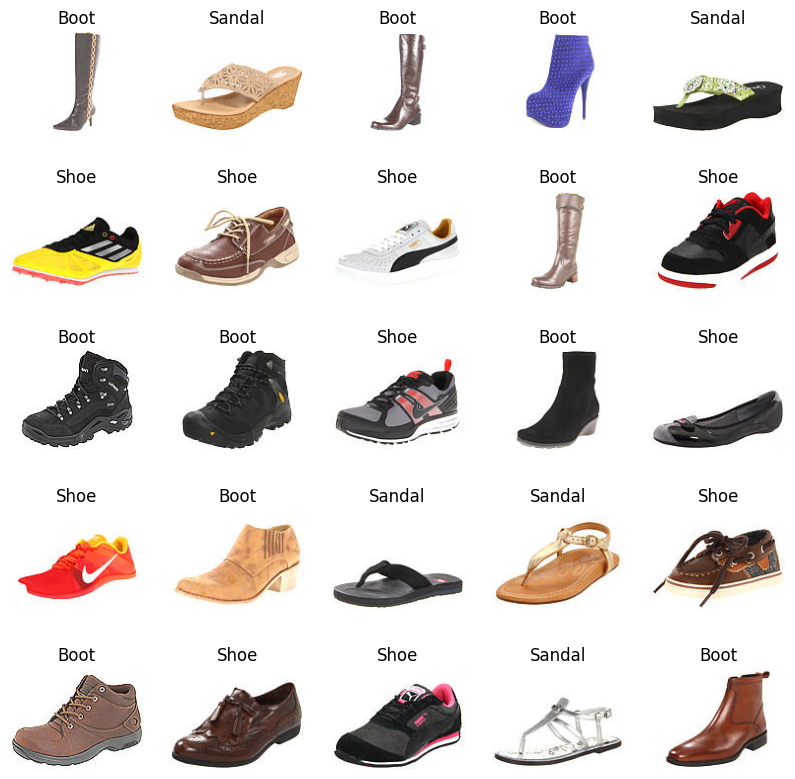

Dataset de Entrenamiento: 12000 muestras
Dataset de Validación: 3008 muestras


In [11]:
dataset = image_dataset_from_directory("dataset/", label_mode="int", batch_size=batch_size, image_size=(102,136), validation_split=0.2, subset="both", shuffle=True, seed=seed)

train_dataset = dataset[0]
val_dataset = dataset[1]

train_dataset_card = tf.data.experimental.cardinality(train_dataset).numpy()
val_dataset_card = tf.data.experimental.cardinality(val_dataset).numpy()

# Training Data
for data, labels in train_dataset.take(1):
    print(data.shape)
    print(labels.shape)

class_names = train_dataset.class_names
print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

print(f"Dataset de Entrenamiento: %d muestras" % (train_dataset_card*batch_size))
print(f"Dataset de Validación: %d muestras" % (val_dataset_card*batch_size))

#### Acondicionando el conjunto de datos

In [12]:
import tensorflow_datasets as tfds

# Normaliza las imágenes llevandolas al rango de [0,1]
# Función de Normalización de Imágenes
def process_image_normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

# Obtenemos el array con las imágenes y las etiquetas de test
# Para poder Evaluar los resultados con la librerìa de sklearn
def convert_dataset_to_numpy(test_dataset):
  # Convierte a numpy array cada elemento del tensor
  test_dict_numpy = tfds.as_numpy(test_dataset)

  # Convierte el diccionario de numpy array devuelto en
  # un array único para imagenes y etiquetas
  arr_test_label = []
  arr_test_image = []
  first_image = True
  for elem in test_dict_numpy:
    if first_image:
      arr_test_image = elem[0]
      arr_test_label = elem[1]
      first_image = False
    else:
      arr_test_image = np.vstack([arr_test_image, elem[0]])
      arr_test_label = np.hstack([arr_test_label, elem[1]])
  return arr_test_image, arr_test_label

# Aplica la Normalización en el dataset de Training y de Validación
train_ds_norm = train_dataset.map(process_image_normalize)
val_ds_norm = val_dataset.map(process_image_normalize)

# Calcula el 80% del tamaño del dataset de Training
train_ds_pt_size = int(tf.data.experimental.cardinality(train_ds_norm).numpy()*0.8)
print('train_ds_pt_size : ', train_ds_pt_size)

# Divide el dataset de entrenamiento en 80% entrenamiento y 20% para test
train_ds_pt = train_ds_norm.shuffle(batch_size,seed=seed).take(train_ds_pt_size).shuffle(batch_size)
test_ds_pt  = train_ds_norm.shuffle(batch_size,seed=seed).skip(train_ds_pt_size)

train_ds_pt_card = tf.data.experimental.cardinality(train_ds_pt).numpy()
print(f"Dataset de Entrenamiento: %d muestras" % (train_ds_pt_card*batch_size))
test_ds_pt_card = tf.data.experimental.cardinality(test_ds_pt).numpy()
print(f"Dataset de Pruebas: %d muestras" % (test_ds_pt_card*batch_size))

# Convierte Dataset a Numpy array
arr_test_image, arr_test_label = convert_dataset_to_numpy(test_ds_pt)

print(arr_test_image.shape)
# print(arr_test_image[0])
print(arr_test_label.shape)
# print(arr_test_label[0])

train_ds_pt_size :  300
Dataset de Entrenamiento: 9600 muestras
Dataset de Pruebas: 2400 muestras
(2400, 102, 136, 3)
(2400,)


In [13]:
print(arr_test_image[10, 80:110, 2])

[[0.99215686 0.99215686 0.99215686]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [0.99215686 0.99215686 0.99215686]
 [0.972549   0.972549   0.972549  ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]]


### Creando la arquitectura de una red Perceptron Multicapa

In [ ]:
# Imports necesarios
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD

# Arquitectura de red - modo API Sequential

mlp = Sequential()
mlp.add(Flatten())
mlp.add(Dense(2048, input_shape=(102*136*3,), activation="relu"))
mlp.add(Dense(1024, activation="relu"))
mlp.add(Dense(512, activation="relu"))
mlp.add(Dense(128, activation="relu"))
mlp.add(Dense(32, activation="relu"))
mlp.add(Dense(10, activation="softmax"))

# Compilamos el modelo y entrenamos

mlp.compile(optimizer=SGD(learning_rate=0.01),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
            )

# Entrenamos el perceptrón multicapa
print("[INFO]: Entrenando la red neuronal...")
H = mlp.fit(train_ds_pt, epochs=5, steps_per_epoch=train_ds_pt_card, validation_data=val_ds_norm)

# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(mlp, arr_test_image, arr_test_label)

[INFO]: Entrenando la red neuronal...
Epoch 1/5
 94/300 [========>.....................] - ETA: 2:24 - loss: 1.2075 - accuracy: 0.4166

#### Creando la Arquitectura de Red Neuronal Convolucional (CNN)

In [ ]:
# Construccion de una red CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Red feedforward API secuencial
convnet = Sequential()

# BASE MODEL
# BM - Bloque Convolución 1
convnet.add(layers.Conv2D(32, (3,3), input_shape=(102,136,3), activation="relu", padding="same"))
convnet.add(layers.MaxPooling2D((2,2)))

# BM - Bloque Convolución 2
convnet.add(layers.Conv2D(64, (3,3), activation="relu", padding="same"))
convnet.add(layers.MaxPooling2D((2,2)))

# BM - Bloque Convolución 3
convnet.add(layers.Conv2D(128, (3,3), activation="relu", padding="same"))
convnet.add(layers.MaxPooling2D((2,2)))

# TOP MODEL
convnet.add(layers.Flatten())
convnet.add(layers.Dense(64, activation="relu"))
convnet.add(layers.Dense(3, activation="softmax"))

convnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 102, 136, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 51, 68, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 51, 68, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 25, 34, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 12, 17, 128)      

In [ ]:
# Compilación
convnet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [ ]:
# Entrenamiento
H = convnet.fit(train_ds_pt, epochs=5, steps_per_epoch=train_ds_pt_card, validation_data=val_ds_norm)

Epoch 1/5
300/300 [==============================] - 20s 23ms/step - loss: 0.3064 - accuracy: 0.8793 - val_loss: 0.1753 - val_accuracy: 0.9350
Epoch 2/5
300/300 [==============================] - 9s 26ms/step - loss: 0.1257 - accuracy: 0.9586 - val_loss: 0.1227 - val_accuracy: 0.9587
Epoch 3/5
300/300 [==============================] - 7s 22ms/step - loss: 0.0806 - accuracy: 0.9727 - val_loss: 0.0943 - val_accuracy: 0.9693
Epoch 4/5
300/300 [==============================] - 7s 20ms/step - loss: 0.0545 - accuracy: 0.9799 - val_loss: 0.0720 - val_accuracy: 0.9800
Epoch 5/5
300/300 [==============================] - 8s 25ms/step - loss: 0.0417 - accuracy: 0.9866 - val_loss: 0.0768 - val_accuracy: 0.9730


[INFO]: Evaluando red neuronal...
75/75 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       789
           1       0.97      0.98      0.97       789
           2       0.98      0.97      0.97       822

    accuracy                           0.98      2400
   macro avg       0.98      0.98      0.98      2400
weighted avg       0.98      0.98      0.98      2400



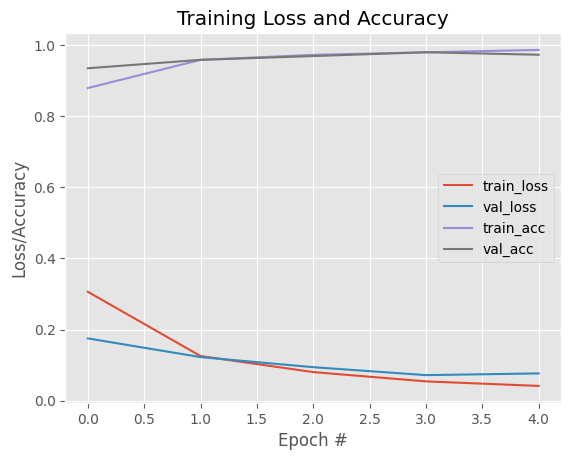

In [ ]:
# Evaluación + Testeo
# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(convnet, arr_test_image, arr_test_label)

^C
